In [1]:
import tensorflow as tf
import datetime
import matplotlib.pyplot as plt
import seaborn as sb
import segmentation_models as sm
import functools as ft
import pandas as pd
import numpy as np
import cv2

sm.set_framework("tf.keras")
sm.framework()

tf.random.set_seed(1024)


2021-11-17 02:47:50.580041: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Segmentation Models: using `keras` framework.


# Data cleaning process


In [2]:
# directory = ["vid-3", "vid-1", "vid-2"]

# directoryone = []

# for thisdir in directory:
#     thisfolder = os.listdir(thisdir)
#     for thispath in thisfolder:
#         if thispath.split('.')[-1] == 'jpg':
#             directoryone.append(os.path.join(os.path.abspath(thisdir), thispath))


# # directoryone
# for idx, file in enumerate(directoryone):
#     os.renames(file, f'images/{idx}.jpg')

#     splits = file.split('.')
#     os.renames(f'{splits[0]}.txt', f'images/{idx}.txt')

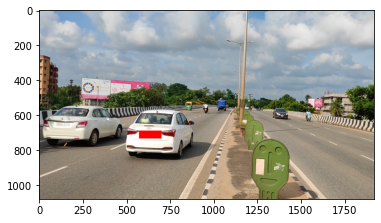

In [3]:
picture = cv2.cvtColor(cv2.imread('images/0.jpg'), cv2.COLOR_BGR2RGB)
picture = cv2.rectangle(picture, [637 - 64, 711 - 22], [637 + 64, 711 + 22], (255, 0, 0), -1)
# picture = cv2.circle(picture, [637 - 64, 711 - 22], 20, (255, 0, 0), -1)

plt.imshow(picture)


In [4]:
def get_image_decode(image, label):
    image = tf.io.read_file(image, "image")
    image = tf.image.decode_image(image)

    [
        label,
    ] = tf.py_function(get_mask, [label], [tf.float32])

    return image, label


def path_2(path):

    [output1, output2] = tf.py_function(
        lambda x: (
            f"images/{x.numpy().decode('utf-8')}.jpg",
            f"images/{x.numpy().decode('utf-8')}.txt",
        ),
        [path],
        [tf.string, tf.string],
    )

    return (output1, output2)


def get_mask(filepath):
    blackimg = np.zeros([1080, 1920], np.int32)
    with open(filepath.numpy().decode("utf-8"), "r") as f:
        for i in f.readlines():
            classncoor = [float(x) for x in i.replace("\n", "").split(" ")]
            x = int(classncoor[1:][0] * 1920)
            y = int(classncoor[1:][1] * 1080)
            width = int(classncoor[1:][2] * 1920)
            height = int(classncoor[1:][3] * 1080)

            halfwidth = width // 2
            halfheight = height // 2

            blackimg = cv2.rectangle(
                blackimg,
                [x - halfwidth, y - halfheight],
                [x + halfwidth, y + halfheight],
                (1),
                -1,
            )

    whiteimg = blackimg <= 127
    blackimg = blackimg
    whiteimg = whiteimg
    whiteimg = np.reshape(whiteimg, [1080, 1920, 1])
    blackimg = np.reshape(blackimg, [1080, 1920, 1])

    return np.concatenate([whiteimg, blackimg], -1)


# [w, h, c], 360, 360, 3
def decode_crop(image, label):
    label = tf.cast(label, tf.float32)

    padding_left = 64
    padding_right = 64
    padding_top = 92
    padding_bottom = 92

    # padding
    image = image[padding_top:-padding_bottom, padding_left:-padding_right, :]
    label = label[padding_top:-padding_bottom, padding_left:-padding_right, :]

    img_array = []
    label_array = []

    for index in range(4 * 8):
        x, y = index // 8, index % 8
        img_array.append(image[224 * x : 224 * (1 + x), 224 * y : 224 * (1 + y)])
        label_array.append(label[224 * x : 224 * (1 + x), 224 * y : 224 * (1 + y)])

    return tf.data.Dataset.from_tensor_slices((img_array, label_array))


def create_ds(batch_size, ratio=0.8):
    AUTOTUNE = tf.data.AUTOTUNE

    paths = [x.split(".")[0] for x in os.listdir("images") if x.find(".jpg") != -1]
    ds = tf.data.Dataset.from_tensor_slices(paths)
    ds = ds.map(path_2, AUTOTUNE)

    ds = ds.cache()

    # get train and test ratio
    takefortrain = int(160 * ratio)
    trainds = ds.take(takefortrain)
    testds = ds.skip(takefortrain).take(160 - takefortrain)

    # shuffle
    trainds = trainds.shuffle(160)

    trainds = trainds.map(get_image_decode, AUTOTUNE)
    testds = testds.map(get_image_decode, AUTOTUNE)

    # break fullhd into chuck
    trainds = trainds.flat_map(decode_crop)
    testds = testds.flat_map(decode_crop)

    # # batch and prefetch
    trainds = trainds.batch(batch_size)
    testds = testds.batch(batch_size)

    trainds = trainds.prefetch(AUTOTUNE)

    return trainds, testds


# trainds, testds = create_ds(1)

# for i, y in trainds.take(10):
#     fig, axs = plt.subplots(1, 3, figsize=(16, 9))
#     axs[0].imshow(i[0])
#     axs[2].imshow(
#         i[0] * tf.cast(tf.repeat(y[0, ..., 1][..., tf.newaxis], 3, -1), tf.uint8)
#     )
#     axs[1].imshow(y[0, ..., 1])

#     fig.savefig('abc.png', dpi=300)

In [9]:
def create_backbone():
    _backbone = tf.keras.applications.EfficientNetB0(
        include_top=False, input_shape=[None, None, 3]
    )

    outputs = [
        layer.output
        for layer in _backbone.layers
        if layer.name
        in [
            "block2a_activation",
            "block3a_activation",
            "block5a_activation",
            "block7a_activation",
        ]
    ]

    return tf.keras.Model(
        inputs=[_backbone.input], outputs=outputs, name="efficientb0_backbone"
    )


class FPN(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(name="Feature_Pyramid_Network", **kwargs)

        self.backbone = create_backbone()
        self.conv5_1x1 = tf.keras.layers.Conv2D(
            filters=256, kernel_size=(1, 1), padding="same"
        )
        self.conv4_1x1 = tf.keras.layers.Conv2D(
            filters=256, kernel_size=(1, 1), padding="same"
        )
        self.conv3_1x1 = tf.keras.layers.Conv2D(
            filters=256, kernel_size=(1, 1), padding="same"
        )
        self.conv2_1x1 = tf.keras.layers.Conv2D(
            filters=256, kernel_size=(1, 1), padding="same"
        )
        self.conv5_3x3_1 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv5_3x3_2 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv5_bn = tf.keras.layers.BatchNormalization()
        self.conv4_3x3_1 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv4_3x3_2 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv4_bn = tf.keras.layers.BatchNormalization()
        self.conv3_3x3_1 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv3_3x3_2 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv3_bn = tf.keras.layers.BatchNormalization()
        self.conv2_3x3_1 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv2_3x3_2 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv2_bn = tf.keras.layers.BatchNormalization()
        self.upscale = tf.keras.layers.UpSampling2D(size=(2, 2))

    def call(self, images, training=False):
        # 112x112, 56x56, 28x28, 14x14
        conv2, conv3, conv4, conv5 = self.backbone(images, training=training)
        conv5_m = self.conv5_1x1(conv5)
        conv5_p = self.conv5_3x3_1(conv5_m)
        conv5_p = self.conv5_3x3_2(conv5_p)
        conv5_p = self.conv5_bn(conv5_p, training=training)

        conv4_m_1 = self.upscale(conv5_m)
        conv4_m_2 = self.conv4_1x1(conv4)
        conv4_m = conv4_m_1 + conv4_m_2
        conv4_p = self.conv4_3x3_1(conv4_m)
        conv4_p = self.conv4_3x3_2(conv4_p)
        conv4_p = self.conv4_bn(conv4_p, training=training)

        conv3_m_1 = self.upscale(conv4_m)
        conv3_m_2 = self.conv3_1x1(conv3)
        conv3_m = conv3_m_1 + conv3_m_2
        conv3_p = self.conv3_3x3_1(conv3_m)
        conv3_p = self.conv3_3x3_2(conv3_p)
        conv3_p = self.conv3_bn(conv3_p, training=training)

        conv2_m_1 = self.upscale(conv3_m)
        conv2_m_2 = self.conv2_1x1(conv2)
        conv2_m = conv2_m_1 + conv2_m_2
        conv2_p = self.conv2_3x3_1(conv2_m)
        conv2_p = self.conv2_3x3_2(conv2_p)
        conv2_p = self.conv2_bn(conv2_p, training=training)
        return conv5_p, conv4_p, conv3_p, conv2_p


class FCN(tf.keras.Model):
    def __init__(self, n_classes=8, **kwargs):
        super().__init__(name="FCN", **kwargs)
        self.fpn = FPN()
        self.upscale_2x = tf.keras.layers.UpSampling2D()
        self.upscale_4x = tf.keras.layers.UpSampling2D((4, 4))
        self.upscale_8x = tf.keras.layers.UpSampling2D((8, 8))
        self.concat = tf.keras.layers.Concatenate()
        self.conv6 = tf.keras.layers.Conv2D(
            filters=(512), kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.bnorm = tf.keras.layers.BatchNormalization()
        self.conv7 = tf.keras.layers.Conv2D(
            filters=n_classes, kernel_size=(1, 1), padding="same", activation="relu"
        )
        self.upscale_final = tf.keras.layers.UpSampling2D(
            size=(4, 4), interpolation="bilinear"
        )
        self.final_activation = tf.keras.layers.Activation("softmax")

    def call(self, images, training=False):
        conv5_p, conv4_p, conv3_p, conv2_p = self.fpn(images, training=training)
        m_5 = self.upscale_8x(conv5_p)
        m_4 = self.upscale_4x(conv4_p)
        m_3 = self.upscale_2x(conv3_p)
        m_2 = conv2_p

        m_all = self.concat([m_2, m_3, m_4, m_5])
        m_all = self.conv6(m_all)
        m_all = self.bnorm(m_all, training=training)
        m_all = self.conv7(m_all)
        m_all = self.upscale_final(m_all)
        m_all = self.final_activation(m_all)

        return m_all


class FCN_ORIG(tf.keras.Model):
    def __init__(self, n_classes=8, **kwargs):
        super().__init__(name="FCN_ORIG", **kwargs)

        self.backbone = create_backbone()
        self.conv1 = tf.keras.layers.Conv2D(
            filters=(n_classes), kernel_size=(1, 1), padding="same", activation="relu"
        )
        self.conv2 = tf.keras.layers.Conv2D(
            filters=(n_classes), kernel_size=(1, 1), padding="same", activation="relu"
        )
        self.conv3 = tf.keras.layers.Conv2D(
            filters=(n_classes), kernel_size=(1, 1), padding="same", activation="relu"
        )
        self.upscale2x_1 = tf.keras.layers.Convolution2DTranspose(
            filters=8,
            kernel_size=(4, 4),
            strides=(2, 2),
            padding="same",
            activation="relu",
        )
        self.upscale2x_2 = tf.keras.layers.Convolution2DTranspose(
            filters=8,
            kernel_size=(4, 4),
            strides=(2, 2),
            padding="same",
            activation="relu",
        )
        self.upscale8x = tf.keras.layers.Convolution2DTranspose(
            filters=8,
            kernel_size=(16, 16),
            strides=(8, 8),
            padding="same",
            activation="relu",
        )
        self.final_activation = tf.keras.layers.Activation("softmax")

    def call(self, images, training=False):
        _, conv1_o, conv2_o, conv3_o = self.backbone(images, training=training)
        conv1_o = self.conv1(conv1_o)
        conv2_o = self.conv2(conv2_o)
        conv3_o = self.conv3(conv3_o)

        fcn_16x = self.upscale2x_1(conv3_o) + conv2_o
        fcn_8x = self.upscale2x_2(fcn_16x) + conv1_o
        final_output = self.upscale8x(fcn_8x)
        final_output = self.final_activation(final_output)
        return final_output


In [10]:
# the network must OUTPUT in logits [-inf, inf]
# make sure input dimension is [B, H, W, C]
def Jindex(target, pred):
    intersection = tf.reduce_sum(target * pred, [0, 1, 2])
    union = tf.reduce_sum(target + pred, [0, 1, 2]) - intersection
    return tf.reduce_mean((intersection + 0.1) / (union + 0.1))


def Dice(target, pred):
    intersection = tf.reduce_sum(2 * pred * target, [0, 1, 2])
    union = tf.reduce_sum(pred + target, [0, 1, 2])
    return tf.reduce_mean((intersection + 0.1) / (union + 0.1))


In [11]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = "logs/tape/" + current_time + "/train"
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_log_dir = "logs/tape/" + current_time + "/test"
test_summary_writer = tf.summary.create_file_writer(test_log_dir)


2021-11-17 02:47:53.568825: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-11-17 02:47:55.049764: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-17 02:47:55.050091: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 950M computeCapability: 5.0
coreClock: 0.928GHz coreCount: 5 deviceMemorySize: 1.96GiB deviceMemoryBandwidth: 74.65GiB/s
2021-11-17 02:47:55.050141: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-11-17 02:47:55.052822: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-11-17 02:47:55.052909: I tensorflow/stream_executor/platf

In [12]:
# this iteration is calculated fom 160 iteration from
# paper
n_epoch = 100
n_classes = 2
batch_size = 4
trainds, testds = create_ds(batch_size)
model = FCN(n_classes)

In [13]:
optimizer = tf.keras.optimizers.Adam(1e-6)
focal_loss = sm.losses.CategoricalFocalLoss()
dice_loss = sm.losses.DiceLoss(class_weights=[0.001, 0.999])

In [14]:
ckpt = tf.train.Checkpoint(model=model, optimizer=optimizer)
ckptmg = tf.train.CheckpointManager(ckpt, "trained_model/fcn2", 5)
ckptmg.restore_or_initialize()


'trained_model/fcn2/ckpt-32'

In [15]:
model.build([None, 448, 448, 3])

model.layers[0].backbone.trainable = True
model.compile()
model.summary()


Model: "FCN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Feature_Pyramid_Network (FPN multiple                  5405939   
_________________________________________________________________
up_sampling2d_1 (UpSampling2 multiple                  0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 multiple                  0         
_________________________________________________________________
up_sampling2d_3 (UpSampling2 multiple                  0         
_________________________________________________________________
concatenate (Concatenate)    multiple                  0         
_________________________________________________________________
conv2d_12 (Conv2D)           multiple                  2359808   
_________________________________________________________________
batch_normalization_4 (Batch multiple                  2048    

# Make sure you configure the preprocessing for each model correctly.

## FCN, FPN used Efficient and Unet used Resnet50

1. ## Resnet50 needs input to be range [0, 1]
2. ## Efficientnet need to range to be [0, 255]


In [16]:
# Real training
train_iteration = 0
iteration = 0
sum_iou = 0
sum_loss = 0
ALPHA = 1.0

for epoch in range(n_epoch):
    for bs_images, bs_labels in trainds:
        # REMEMBER HERE
        # Comment below if you are training FPN and ORIG_FCN
        # bs_images = sm.get_preprocessing('resnet')(bs_images)

        with tf.GradientTape() as t:
            output = model(bs_images)
            c_loss = dice_loss(bs_labels, output) + ALPHA * focal_loss(
                bs_labels, output
            )

        grad = t.gradient(c_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grad, model.trainable_variables))
        sum_loss = c_loss
        train_iteration += 1

        # print(
        #     tf.reduce_max(output).numpy(),
        #     tf.reduce_min(output).numpy(),
        #     tf.reduce_max(bs_labels).numpy(),
        #     tf.reduce_min(bs_labels).numpy(),
        #     sm.metrics.iou_score(bs_labels, output).numpy(),
        # )

        # calculate loss and IoU at iteration
        # this is train
        with train_summary_writer.as_default():
            tf.summary.scalar("loss", c_loss, step=train_iteration)
            tf.summary.scalar(
                "iou", sm.metrics.iou_score(bs_labels, output), step=train_iteration
            )

    for bs_images, bs_labels in testds:
        output = model(bs_images, training=False)
        sum_loss += (
            dice_loss(bs_labels, output) + ALPHA * focal_loss(bs_labels, output)
        ) * batch_size
        sum_iou += sm.metrics.iou_score(bs_labels, output) * batch_size
        iteration += batch_size

    # calculate validation loss and IoU
    # this is test
    with test_summary_writer.as_default():
        tf.summary.scalar("loss", sum_loss / iteration, step=train_iteration)
        tf.summary.scalar("iou", sum_iou / iteration, step=train_iteration)

    iteration = 0
    sum_iou = 0
    sum_loss = 0
    ckptmg.save()

2021-11-17 02:48:01.629181: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-17 02:48:01.629784: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2693710000 Hz
2021-11-17 02:48:01.773406: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2021-11-17 02:48:01.961581: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-11-17 02:48:02.304154: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8100
2021-11-17 02:48:02.641966: I tensorflow/stream_executor/